# Permutation testing
Null: there is no relationship between location of flares and the CA minority population ('MINORPOP').
Alt: there is a relationship between flare location and the CA minority population.

Statistic: difference in proportion of MINORPOP within a 5km buffer of any flare versus the MINORPOP proportion outside the flares buffer.

1) Calculate the actual test statistic  
2) Randomize the buffer_present binary variable  
3) Re-calculate proportion of each BG intersecting with a buffer  
5) Calculate the statistics based on the new overlay  
6) Put stats into a new df for storage  
7) visualize the stats with a density plot

In [1]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly
import folium

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

### Read in file, setup

In [3]:
df = pd.read_csv("data/bgformodel_permutation.csv")

In [4]:
df['MINORPOP_bg_totprop'] = df['MINORPOP'] / df['ACSTOTPOP']

## NOTE setup / testing using random numbers and proportions


In [5]:

# add the column of random proportions to the dataframe
df['buffer_present'] = np.random.randint(2, size=len(df))
df['intersect_prop'] = np.random.rand(len(df))
df.loc[df['buffer_present'] == 0, 'intersect_prop'] = 0
df['intersect_area'] = df['intersect_prop'] * df['Shape_Area']

In [6]:
df.head(3)

,Unnamed: 0,ID,CNTY_NAME,Shape_Area,ACSTOTPOP,UNDER5,OVER64,MINORPOP,LOWINCOME,D_PM25_2,geometry,MINORPOP_bg_totprop,buffer_present,intersect_prop,intersect_area
0,0,60376500012,Los Angeles County,"406,992.50",864,92,154,576,42,34.33,"POLYGON ((-118.326488 33.882821, -118.32541 33...",0.67,1,0.66,"269,148.93"
1,1,60376500014,Los Angeles County,"433,085.47",748,0,162,646,80,46.59,"POLYGON ((-118.326469 33.879784, -118.326469 3...",0.86,0,0.00,0.00
2,2,60376503002,Los Angeles County,"596,582.85",1149,39,380,895,105,41.34,"POLYGON ((-118.352498 33.87249, -118.352497 33...",0.78,0,0.00,0.00


In [7]:
inbuffer_wt_prop = np.sum(df['MINORPOP_bg_totprop'] * df['intersect_prop']) / sum(df['intersect_prop'])

In [8]:
df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']]
df.to_csv("data/test_permutation.csv")

In [9]:
inbuffer_wt_prop

0.6003664653504537

### Permutation

In [10]:
# def get_buffer_proportion(dataframe):
#     inbuffer_wt_prop = np.sum(dataframe['MINORPOP_bg_totprop'] * dataframe['intersect_prop']) / sum(dataframe['intersect_prop'])
#     outbuffer_wt_prop = 1-inbuffer_wt_prop
#     return inbuffer_wt_prop - outbuffer_wt_prop

In [11]:
# actual_value = get_buffer_proportion(df)

# n_sim = 100

# results = pd.DataFrame({'statistic': np.concatenate(([actual_value], np.full(n_sim, np.nan)))})

# new_df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']].copy()


# for i in range(1, n_sim+1):
#     new_df['buffer_present'] = np.random.randint(2, size=len(df))
#     results.loc[i, 'statistic'] = get_buffer_proportion(new_df)

# pval = (np.abs(results['statistic'] >= actual_value)).mean()

# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(results['statistic'], kde=True, color='blue', element='step', stat='density')
# plt.axvline(x=actual_value, color='red')
# plt.show()
# print(f' P value is {pval}')
# print(f' Orig diff in proportions is {round(actual_value, 2)}')

### Updated permutation code

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt



In [17]:
df.head(10)

,MINORPOP_bg_totprop,intersect_prop,buffer_present
0,0.67,0.66,1
1,0.86,0.00,0
2,0.78,0.00,0
3,0.77,0.48,1
4,0.76,0.00,0
5,0.75,0.60,1
6,0.87,0.26,1
7,0.90,0.11,1
8,0.88,0.70,1
9,0.72,0.00,0


1.0


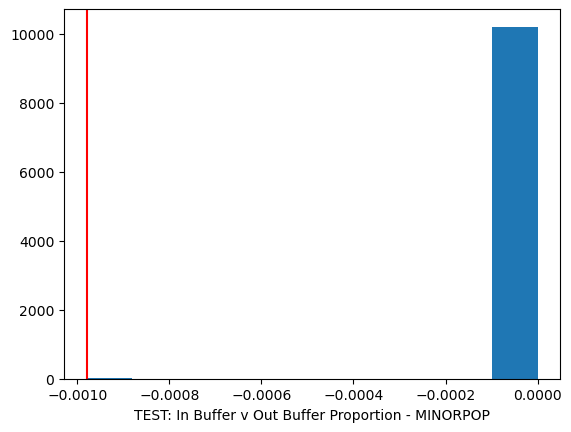

In [18]:
def get_prop_diff(x):
    in_buffer = np.sum(x['MINORPOP_bg_totprop'] * x['intersect_prop']) / np.sum(x['intersect_prop'])
    out_buffer = np.sum(x['MINORPOP_bg_totprop'] * (1 - x['intersect_prop'])) / np.sum(1 - x['intersect_prop'])
    return(in_buffer - out_buffer)

actual_value = get_prop_diff(df)

n_sim = 1000

results = pd.DataFrame({'statistic': [actual_value] + [np.nan] * n_sim})

new_df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']]

np.random.seed(42)

for i in range(1, n_sim + 1):
    #new_df['buffer_present'] = np.random.choice(new_df['buffer_present'])
    new_df['intersect_prop'] = np.random.choice(new_df['intersect_prop'])
    
    # To do this for real the spatial calculation of proportions will need
    # to be added to this step instead of the random proportion generator
    #new_df['intersect_prop'] = np.where(new_df['buffer_present'] == 0, 0, uniform.rvs(size=len(new_df)))
    
    results.loc[i, 'statistic'] = get_prop_diff(new_df)

pval = np.mean(np.abs(results['statistic']) >= actual_value)
print(pval)

plt.hist(results['statistic'], density=True)
plt.axvline(x=actual_value, color='red')
plt.xlabel('TEST: In Buffer v Out Buffer Proportion - MINORPOP')
plt.ylabel('')
plt.show()

In [19]:
print(f" Proportion of permutation stats equal to or more extreme than actual: {round(np.mean(results['statistic'] >= actual_value),2)}")
print(f" P-value: {round(pval,2)}")

 Proportion of permutation stats equal to or more extreme than actual: 1.0
 P-value: 1.0
